In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from bootstrap import ar1_bstr, ema_bstr, kf_bstr, svm_bstr, get_Y
#from bootstrap import pp_bstr
import import_ipynb
from EMA_Bootstrap import ema_bootstrap
from MACD_bootstrap import bootstrap
from SVM_bootstrap import svm_bstr
from Autoregression_Bootstrap import AR_bootstrap
from pandas_datareader import DataReader
from datetime import datetime
# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=6e3dabc79a216eb37fb5812946488f4b40c3cbfe795b57b2c92f956edeabe7d7
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [8]:
facebook = DataReader('FB',  'yahoo', datetime(2016,4,1), datetime(2019,9,1));
facebook.reset_index(inplace=True,drop=False)
facebook.set_index('Date')
facebook['OpenTmr'] = facebook['Open'].shift(-1)
facebook['CloseTmr'] = facebook['Close'].shift(-1)
facebook['OpenClose']= (facebook['Open']+ facebook['Close'])/2
facebook['HighLow'] = (facebook['High']+ facebook['Low'])/2
facebook['OCHL'] = (facebook['Open']+ facebook['Close']+facebook['High']+ facebook['Low'])/4
facebook['CloseYest'] = facebook['Close'].shift(-1)
facebook['Close2dayBefore'] = facebook['Close'].shift(-2)
#facebook.head()
facebook=facebook.set_index('Date')
facebook.index = facebook.index.map(lambda x: x.strftime('%Y-%m-%d'))
facebook = facebook.dropna(0)
facebook.tail()

,High,Low,Open,Close,Volume,Adj Close,OpenTmr,CloseTmr,OpenClose,HighLow,OCHL,CloseYest,Close2dayBefore
Date,,,,,,,,,,,,,
2019-08-22,184.110001,179.910004,183.429993,182.039993,10821400,182.039993,180.839996,177.750000,182.734993,182.010002,182.372498,177.750000,180.360001
2019-08-23,183.130005,176.660004,180.839996,177.750000,17323400,177.750000,179.399994,180.360001,179.294998,179.895004,179.595001,180.360001,181.300003
2019-08-26,180.500000,178.240005,179.399994,180.360001,8773600,180.360001,181.929993,181.300003,179.879997,179.370003,179.625000,181.300003,181.759995
2019-08-27,184.039993,181.009995,181.929993,181.300003,14399600,181.300003,180.529999,181.759995,181.614998,182.524994,182.069996,181.759995,185.570007
2019-08-28,181.949997,178.919998,180.529999,181.759995,9386100,181.759995,183.770004,185.570007,181.144997,180.434998,180.789997,185.570007,185.669998


In [9]:
N = facebook.shape[0] 
num_boot = 300 # total num bootstrap
T= 250 # start day
window = 200 # training period window
Y =facebook['OpenTmr'][-(N-(T+1)):].values
Y_close = facebook['CloseTmr'][-(N-(T+1)):].values

In [10]:
facebook.corr()

,High,Low,Open,Close,Volume,Adj Close,OpenTmr,CloseTmr,OpenClose,HighLow,OCHL,CloseYest,Close2dayBefore
High,1.000000,0.997625,0.998500,0.998287,-0.062786,0.998287,0.994649,0.992300,0.999225,0.999419,0.999385,0.992300,0.986420
Low,0.997625,1.000000,0.997932,0.998573,-0.108002,0.998573,0.994994,0.992618,0.999085,0.999393,0.999301,0.992618,0.986683
Open,0.998500,0.997932,1.000000,0.996670,-0.078632,0.996670,0.992821,0.990889,0.999166,0.998812,0.999052,0.990889,0.985167
Close,0.998287,0.998573,0.996670,1.000000,-0.087097,1.000000,0.996488,0.993616,0.999169,0.999022,0.999158,0.993616,0.987473
Volume,-0.062786,-0.108002,-0.078632,-0.087097,1.000000,-0.087097,-0.089579,-0.096890,-0.082937,-0.085189,-0.084068,-0.096890,-0.103371
Adj Close,0.998287,0.998573,0.996670,1.000000,-0.087097,1.000000,0.996488,0.993616,0.999169,0.999022,0.999158,0.993616,0.987473
OpenTmr,0.994649,0.994994,0.992821,0.996488,-0.089579,0.996488,1.000000,0.996667,0.995485,0.995411,0.995510,0.996667,0.990871
CloseTmr,0.992300,0.992618,0.990889,0.993616,-0.096890,0.993616,0.996667,1.000000,0.993081,0.993047,0.993126,1.000000,0.993616
OpenClose,0.999225,0.999085,0.999166,0.999169,-0.082937,0.999169,0.995485,0.993081,1.000000,0.999750,0.999937,0.993081,0.987143
HighLow,0.999419,0.999393,0.998812,0.999022,-0.085189,0.999022,0.995411,0.993047,0.999750,1.000000,0.999937,0.993047,0.987137


([<matplotlib.axis.YTick at 0x7f103189ff60>,
 [Text(0, 0, 'High'),
  Text(0, 0, 'Low'),
  Text(0, 0, 'Open'),
  Text(0, 0, 'Close'),
  Text(0, 0, 'Volume'),
  Text(0, 0, 'Adj Close'),
  Text(0, 0, 'OpenTmr'),
  Text(0, 0, 'CloseTmr'),
  Text(0, 0, 'OpenClose'),
  Text(0, 0, 'HighLow'),
  Text(0, 0, 'OCHL'),
  Text(0, 0, 'CloseYest'),
  Text(0, 0, 'Close2dayBefore')])

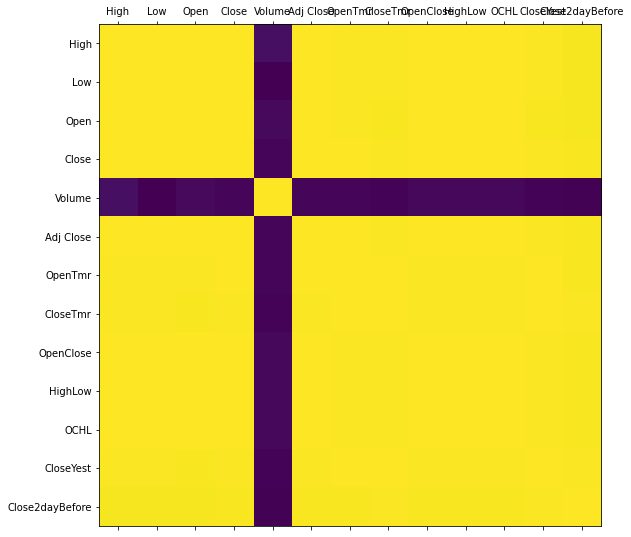

In [11]:
import seaborn as sns
plt.matshow(facebook.corr())
plt.xticks(range(len(facebook.columns)),facebook.columns)
plt.yticks(range(len(facebook.columns)),facebook.columns)

In [12]:

yhat_ar1, rmse_ar1 = AR_bootstrap()    
yhat_ema, rmse_ema = ema_bootstrap()
#yhat_pp, rmse_pp = pp_bstr()  # too slow 
yhat_macd, rmse_macd = bootstrap()
#num_boot = 1
yhat_svm, rmse_svm = svm_bstr()
    
print("AR_RMSE: ", rmse_ar1)
print("EMA_RMSE: ", rmse_ema)
print("MACD_RMSE: ", rmse_macd)
#print("kf_RMSE: ", rmse_kf)
print("SVM_RMSE: ", rmse_svm)

AR_RMSE:  1.9076290240331346
EMA_RMSE:  5.050240539306411
MACD_RMSE:  5.1444098494264665
SVM_RMSE:  32.13436242678203


In [13]:
def random_forest():
    "random forest voting"
    T=Y.shape[0]-1
    print(T)
    Y_rf = np.zeros(T)
    for t in range(0, T):
        if min(abs(yhat_ema[t]-Y[t]),abs(yhat_macd[t]-Y[t]),abs(yhat_ar1[t]-Y[t]),
               abs(yhat_svm[t]-Y[t]))==abs(yhat_ema[t]-Y[t]):
            Y_rf[t] = yhat_ema[t]
        elif min(abs(yhat_ema[t]-Y[t]),abs(yhat_macd[t]-Y[t]),abs(yhat_ar1[t]-Y[t]),
                 abs(yhat_svm[t]-Y[t]))==abs(yhat_macd[t]-Y[t]):
            Y_rf[t] = yhat_macd[t]
        elif min(abs(yhat_macd[t]-Y[t]),abs(yhat_ema[t]-Y[t]),abs(yhat_svm[t]-Y[t]),
                 abs(yhat_ar1[t]-Y[t]))==abs(yhat_ar1[t]-Y[t]):
            Y_rf[t] = yhat_ar1[t]          
        else:
            Y_rf[t] = yhat_svm[t]  
    
    rmse_rf=np.sqrt(np.mean((Y[:-1]-Y_rf)**2))
    print("random forest rmse: ", rmse_rf)
    return Y, Y_rf, Y_close

In [14]:
Y, Y_rf, Y_close = random_forest()

607
random forest rmse:  1.6315203406387442


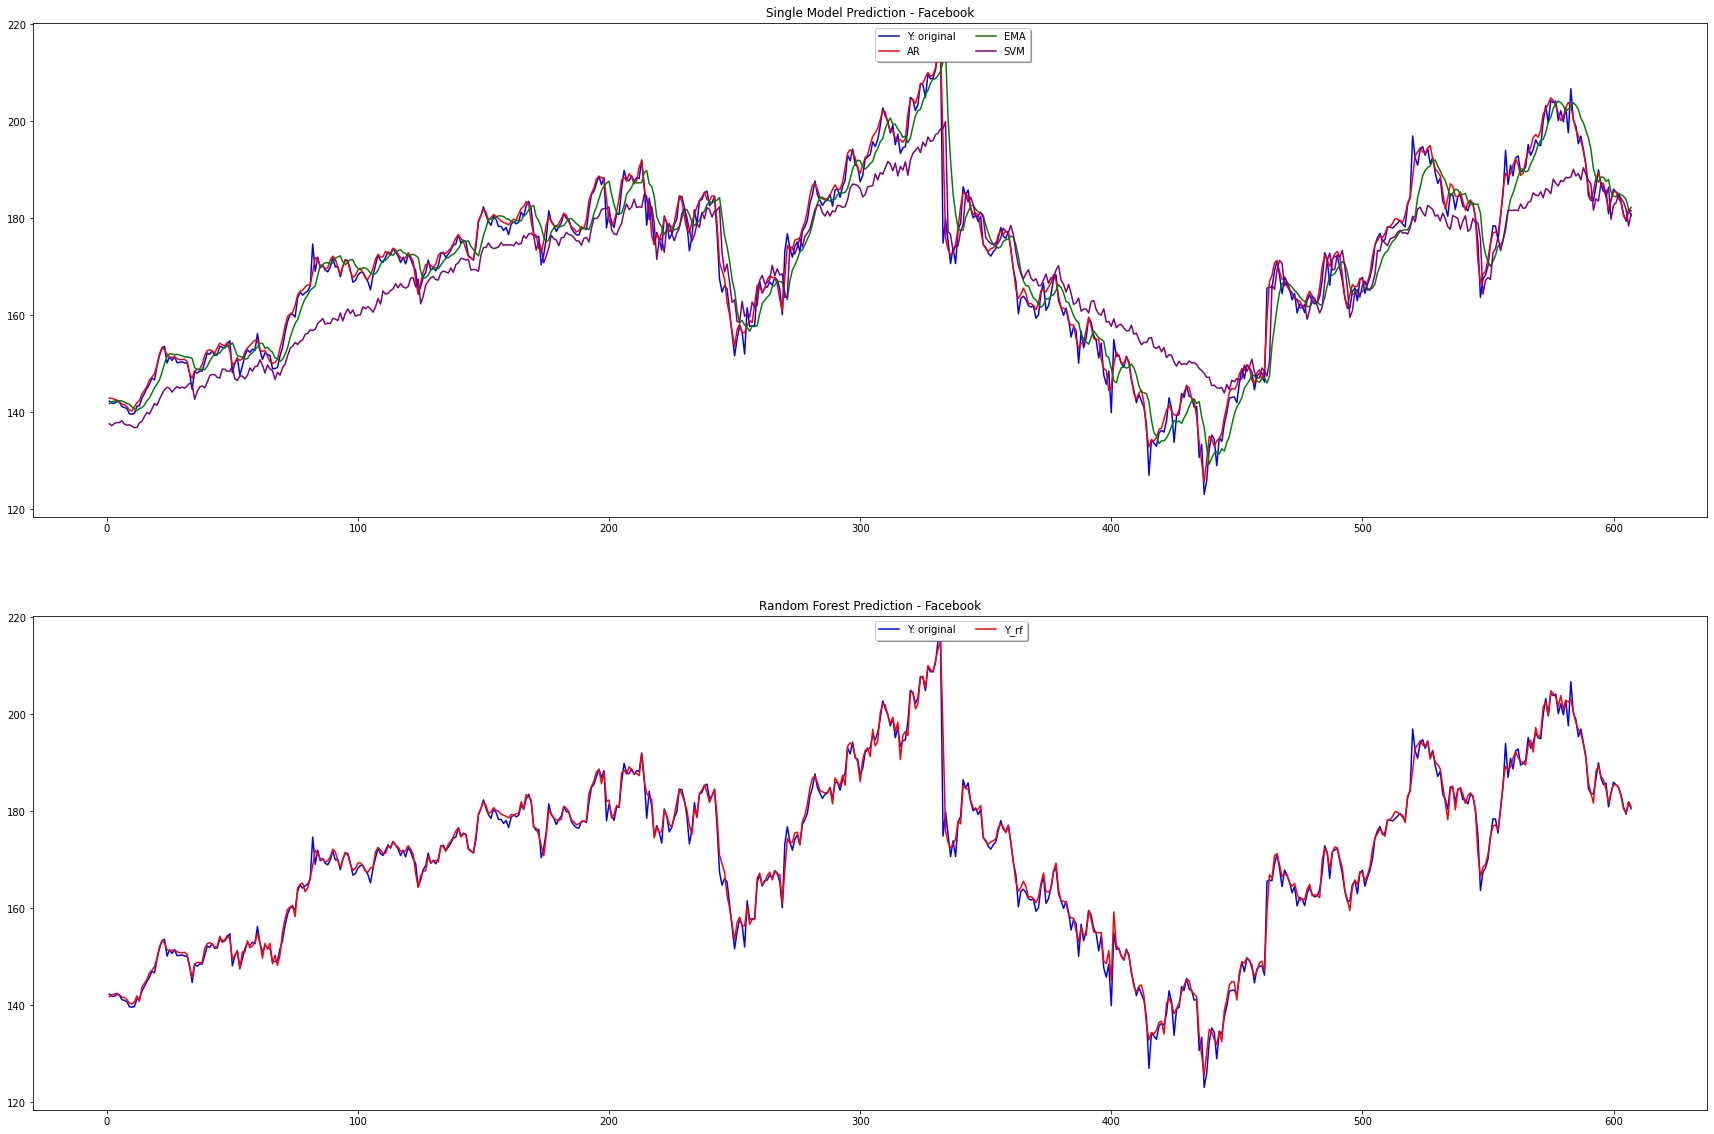

In [19]:
timevec = np.linspace(1,607,607)
plt.figure(figsize=(30,20))
ax = plt.subplot(211)
ax.plot(timevec, Y[:-1], 'blue', label = "Y: original")
ax.plot(timevec, yhat_ar1[:-1], 'red', label = "AR")
ax.plot(timevec, yhat_ema[:-3], 'green', label = "EMA")
ax.plot(timevec, yhat_svm[:-3], 'purple', label = "SVM")
plt.title('Single Model Prediction - Facebook')
ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
ax = plt.subplot(212)
ax.plot(timevec, Y[:-1], 'blue', label = "Y: original")
ax.plot(timevec, Y_rf, 'red', label = "Y_rf")
plt.title('Random Forest Prediction - Facebook')
ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.show()

In [20]:
facebook.tail()

,High,Low,Open,Close,Volume,Adj Close,OpenTmr,CloseTmr,OpenClose,HighLow,OCHL,CloseYest,Close2dayBefore
Date,,,,,,,,,,,,,
2019-08-22,184.110001,179.910004,183.429993,182.039993,10821400,182.039993,180.839996,177.750000,182.734993,182.010002,182.372498,177.750000,180.360001
2019-08-23,183.130005,176.660004,180.839996,177.750000,17323400,177.750000,179.399994,180.360001,179.294998,179.895004,179.595001,180.360001,181.300003
2019-08-26,180.500000,178.240005,179.399994,180.360001,8773600,180.360001,181.929993,181.300003,179.879997,179.370003,179.625000,181.300003,181.759995
2019-08-27,184.039993,181.009995,181.929993,181.300003,14399600,181.300003,180.529999,181.759995,181.614998,182.524994,182.069996,181.759995,185.570007
2019-08-28,181.949997,178.919998,180.529999,181.759995,9386100,181.759995,183.770004,185.570007,181.144997,180.434998,180.789997,185.570007,185.669998


## Professionalism
50% Minghao Ru

50% Tong Yang


## Licensing
Copyright <2020> Minghao Ru, Tong Yang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.